PDE with corner singularity
===========================

\begin{align*}
    -\Delta u &= 1 \text{ in } \Omega \\
    u &= 0 \text{ on } \partial \Omega
\end{align*}

With $\Omega=([-1, 1] \times [-1, 1]) \setminus ([0, 1] \times \{0\})$

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torchphysics as tp 
import torch
X = tp.spaces.R1('x') 
Y = tp.spaces.R1('y')
U = tp.spaces.R1('u') # output is 1D and named u

In [11]:
square = tp.domains.Parallelogram(X*Y, [-1, -1], [1, -1], [-1, 1])
line = tp.domains.Interval(X, 0, 1) * tp.domains.Point(Y, 0)

In [12]:
model = tp.models.DeepRitzNet(input_space=X*Y, output_space=U, width=20, depth=4)

In [13]:
def bound_residual(u, x):
    return u**2

bound_sampler = tp.samplers.RandomUniformSampler(square.boundary, n_points=40000)
bound_sampler += tp.samplers.RandomUniformSampler(line, n_points=10000)

bound_cond = tp.conditions.DeepRitzCondition(module=model, sampler=bound_sampler, 
                                             integrand_fn=bound_residual, weight=100)

In [14]:
def energy_residual(u, x, y):
    grad_term = torch.sum(tp.utils.grad(u, x, y)**2, dim=1, keepdim=True)
    return 0.5*grad_term - u

pde_sampler = tp.samplers.RandomUniformSampler(square, n_points=100000) 
pde_cond = tp.conditions.DeepRitzCondition(module=model, sampler=pde_sampler, 
                                           integrand_fn=energy_residual, weight=1.0)

In [15]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver(train_conditions=[bound_cond, pde_cond], optimizer_setting=optim)

In [18]:
import pytorch_lightning as pl

trainer = pl.Trainer(gpus=1, # or None if CPU is used
                     max_steps=5000, # number of training steps
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 3.4 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [20]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.05, 
                            optimizer_args={'max_iter': 2, 'history_size': 100})

pde_cond.sampler = pde_cond.sampler.make_static() 
bound_cond.sampler = bound_cond.sampler.make_static() 
solver = tp.solver.Solver(train_conditions=[bound_cond, pde_cond], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     max_steps=3000, # number of training steps
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 3.4 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

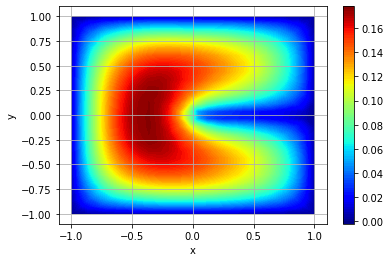

In [21]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=square, n_points=640, device='cuda')
fig = tp.utils.plot(model, lambda u : u, plot_sampler, plot_type='contour_surface')